In [1]:
Folder='./'
DataNameBasis='/'
verbose=True

# Load the data

[Application],Enconding=UTF-8,Date="1/8/2024",Time="14:01:07",Software="HPD-TA",Application=2,ApplicationTitle="High Performance Digital Temporal Analyzer",SoftwareVersion="9.5 pf11",SoftwareDate="01.07.2021"
[Camera],CameraName="C13440-20C",SerialNumber="S/N: 306629",DCAMAPIVERSION="4.00",BUS="AS-FBD-1XCLD-2PE4L",VENDOR="Hamamatsu",CAMERAVERSION="4.31.C",DRIVERVERSION="8.13.30.6307",MODULEVERSION="21.7.4322.6307",Type=34,Binning="1",BinningKeyVal="2 x 2",ScanMode="2",ScanModeKeyVal="Subarray",HOffs="176",HWidth="672",VOffs="258",VWidth="508",TriggerMode="3",TriggerModeKeyVal="Internal",TriggerPolarity="1",TriggerPolarityKeyVal="neg.",ScanSpeed="2",Prop_SensorMode=1,Prop_ReadoutDirection=5,Prop_Colortype=1,Prop_BitPerChannel=16,Prop_TriggerGlobalExposure=5,Prop_TriggerConnector=2,Prop_TriggerTimes=1,Prop_TriggerDelay=0,Prop_InternalTriggerHandling=1,Prop_SensorCoolerStatus=2,Prop_DefectCorrectMode=2,Prop_HotPixelCorrectLevel=1,Prop_IntensityLutMode=1,Prop_IntensityLutPage=1,Prop_Extrac

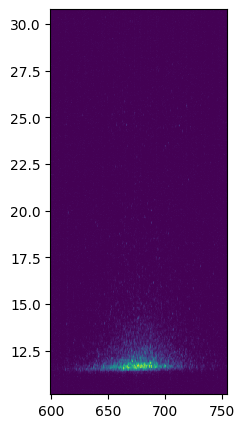

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt


File=glob.glob(Folder+DataNameBasis+"*.img")

########################
#Load and parse the file
########################
file=open(File[0],mode='rb')
data_raw=file.read()
IndexDataStart=np.frombuffer(data_raw[2:4], dtype=np.dtype('u2'))[0]+64

if verbose==True:
    print(data_raw[64:IndexDataStart].decode())

########################
#Recover image basic parameter
########################
BitDepth=np.frombuffer(data_raw[12:13], dtype=np.dtype('u1'))
BytesPerPixel=int(data_raw[data_raw.find(b'BytesPerPixel')+14: \
                                      data_raw.find(b'BytesPerPixel')+15].decode())

#It can't be that there is more than 2048 pixel which should then show as as 4 char
#so we split to only slect the right amount of character
ImgWidth=int(data_raw[data_raw.find(b'HWidth')+8: \
                                      data_raw.find(b'HWidth')+13].decode().split('"')[0])
ImgHeight=int(data_raw[data_raw.find(b'VWidth')+8: \
                                      data_raw.find(b'VWidth')+13].decode().split('"')[0])

IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart

########################
#Recover the unit for the different axis
########################

TimeUnit=data_raw[data_raw.find(b'ScalingYUnit'): \
                                      data_raw.find(b'ScalingYUnit')+18].decode().split('"')
XUnit=data_raw[data_raw.find(b'ScalingXUnit'): \
                                      data_raw.find(b'ScalingXUnit')+18].decode().split('"')

if TimeUnit[1]=='' :
    Time=np.linspace(-1,1,ImgHeight)
    TimeUnit[1]='a.u'
if XUnit[1]=='':
    x=np.linspace(-1,1,ImgWidth)
    XUnit[1]='a.u'
elif TimeUnit[1]=='a.u'  and XUnit[1]!='':
    print('a')
    x=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
elif TimeUnit[1]!='' and XUnit[1]!='':
    temp=np.frombuffer(data_raw[IndexDataEnd:], dtype=np.dtype('<f4'))
    x=temp[0:ImgWidth]
    Time=temp[ImgWidth:]

Data_kin=np.zeros([len(File),ImgHeight,ImgWidth],dtype='f8')
Data_gif=np.zeros([len(File),ImgHeight,ImgWidth],dtype='f8')
TimeExp=np.zeros([len(File),1])
images = []

for i,File_temp in enumerate(File):
    file=open(File_temp,mode='rb')
    data_raw_kin=file.read()
    file.close()
    IndexDataStart=np.frombuffer(data_raw_kin[2:4], dtype=np.dtype('u2'))[0]+64
    IndexDataEnd=ImgWidth*ImgHeight*BytesPerPixel+IndexDataStart
    
    TimeTemp=data_raw_kin[data_raw_kin.find(b'Time'): \
                                      data_raw_kin.find(b'Time')+16].decode().split('"')
    #print(TimeTemp)
    try:
        TimeExp[i]=int(TimeTemp[1].split(':')[0])*3600+int(TimeTemp[1].split(':')[1])*60+int(TimeTemp[1].split(':')[2][:2])
    except:
        if i==1:
            TimeExp[0]=0
        TimeExp[i]=float(TimeTemp[1].split('ms')[0])
    if BytesPerPixel==4:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u4')), newshape=(ImgHeight, ImgWidth))
    elif BytesPerPixel==2:
        temp=np.reshape(np.frombuffer(data_raw_kin[IndexDataStart:IndexDataEnd], dtype=np.dtype('<u2')), newshape=(ImgHeight, ImgWidth))
    Data_kin[i,:,:]=temp

TimeExp=np.round(TimeExp-TimeExp[0],0)

if len(File)==1:
    fig1=plt.figure(figsize=(5,5))
    ax1 =plt.subplot(1,2,1)
    ax1.pcolormesh(x,Time,Data_kin[0,:,:])
    


# Data fitting (first spectra)

## Function to minimize
The way scipy.differential_evolution works is by minimizing a given function  

In [3]:
import matplotlib.pyplot as plt
from scipy.signal import convolve as cv
ScalingParameterG=[1,100,10]

def Step(x):
	'''Heaviside step function'''
	step = np.ones_like(x,dtype='float64')
	step[x<0] = 0
	step[x==0] = 0.5
	return step

def IRFGaussian(x,a,b,c):
	return np.array(a*np.exp(-0.5*np.power((x-b)/(c),2)),dtype='float64')

'''
def BiexpFunc(x,a,b,c,d):
     return np.array(Step(x)*(a * np.exp( -(x/(b))) +
                    c * np.exp( -(x/(d)))),dtype='float32')
'''
def BiexpFunc(x,a,b,c,d,t0):
     return np.array(Step(x-t0)*(a * np.exp( -((x-t0)/(b))) +
                    c * np.exp( -((x-t0)/(d)))),dtype='float64')


def Convolve(f,g):
	#Assume that f and g are 1D numpy array of the same size.'
	# First we create a big array which assume that we only have noise at the
	# beginning and end of the array.
	npts = min(len(f), len(g))
	pad = np.ones(npts,dtype='float64')
	tmp = np.concatenate((pad*f[0], f, pad*f[-1]),dtype='float64')
	norm = np.sum(f)
	#Then we convolve the array and only the overlap will have a correct value
	out = cv(tmp, g, mode='valid')
	#We compute this overlap and cut the out vector.
	noff = int((len(out) - npts)/2)
	return out[noff:noff+npts]/norm


def FittingFunction(x,a_gauss,b_gauss,c_gauss,a_exp,b_exp,c_exp,d_exp,t0,cst):
	temp_gauss=IRFGaussian(x,a_gauss,b_gauss,c_gauss)
	temp_exp=BiexpFunc(x,a_exp,b_exp,c_exp,d_exp,t0)
	return Convolve(temp_exp,temp_gauss)+cst

def FittingFunction2(x,a_gauss,b_gauss,c_gauss,a_exp,b_exp,c_exp,d_exp,t0):
	temp_gauss=IRFGaussian(x,a_gauss,b_gauss,c_gauss)
	temp_exp=BiexpFunc(x,a_exp,b_exp,c_exp,d_exp,t0)
	return Convolve(temp_gauss,temp_exp)

def FittingFunction3(x,a_gauss,b_gauss,c_gauss,a_exp,b_exp,c_exp,d_exp,cst):
	temp_gauss=IRFGaussian(x,a_gauss,b_gauss,c_gauss)
	temp_exp=BiexpFunc(x,a_exp,b_exp,c_exp,d_exp,b_gauss)
	return Convolve(temp_gauss,temp_exp)+cst

def FittingFunctionDiffEvolution(para,data):
	x=data[0]
	y=data[1]
	return np.sum(np.power(y-FittingFunction(x,para[0],para[1],para[2],para[3],para[4],para[5],para[6],para[7],para[8]),2),dtype='float64')

def FittingFunctionDiffEvolution2(para,data):
	x=data[0]
	y=data[1]
	return np.sum(np.power(y-FittingFunction2(x,para[0],para[1],para[2],para[3],para[4],para[5],para[6],para[7]),2),dtype='float64')

def FittingFunctionDiffEvolution3(para,data):
	x=data[0]
	y=data[1]
	return np.sum(np.power(y-FittingFunction3(x,para[0],para[1],para[2],para[3],para[4],para[5],para[6],para[7]),2),dtype='float64')

def Gaussian(x,a,b,c):
	return np.array(a*ScalingParameterG[0] * np.exp(-0.5*np.power((x-b*ScalingParameterG[1])/(c*ScalingParameterG[2]),2)),dtype='float64')


In [4]:
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import chisquare 
from scipy.stats import chi2 
from scipy.optimize import dual_annealing
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


###############
#Parameter
###############
irf=0.2 #IRF depends on calibration
Time_max=20
Time_min=0.9
WavelengthAvg=15
ConfidenceLevel=0.05
print('The spectra will be averaged over a wavelength range of {} nm'.format(np.abs(x[2*WavelengthAvg]-x[0])))

###############
#Variable creation
###############
Time_interp=np.linspace(0,(np.max(Time)-np.min(Time))*0.8,num=1000)

# Multi exponential fitting
Data_fit_s=np.empty([len(File),Time.shape[0]])
Data_exp_s=np.empty([len(File),Time.shape[0]])
ChiSqr=np.empty(len(File))
tau_fit=np.zeros([len(File),2])

#Gaussian fitting
WavePeak=np.empty(len(File))
Max_int_Theoritical=np.empty(len(File))
Max_int=np.empty(len(File))
Rsq_kin=np.empty(len(File))



for i,File_temp in enumerate(File):

    Time_max_index=np.unravel_index(Data_kin[i,:,:].argmax(), Data_kin[i,:,:].shape)[0]
    
    #First we try to fit to a gaussian to find rougly the center of the peak 
    data_fit_Gaussian=np.squeeze(np.mean(Data_kin[i,Time_max_index-10:Time_max_index+10,:],0))
    
    IntNormaGaussian=np.max(data_fit_Gaussian)
    data_fit_Gaussian=data_fit_Gaussian/IntNormaGaussian


    ########################
    #Gaussian fit
    ########################

    popt, pcov = curve_fit(Gaussian,x,data_fit_Gaussian,p0=[1,7.30,5.0])
    curvey = Gaussian(x,popt[0],popt[1],popt[2])


    Max_int_Theoritical[i]=np.max(curvey)*IntNormaGaussian*ScalingParameterG[0]
    Max_int[i]=np.max(data_fit_Gaussian)*IntNormaGaussian
    WavePeak[i]=popt[1]*ScalingParameterG[1]

    #################### 
    # Slicing data
    #################### 
    # We now take a slice in time at the theoritical maximum and try to fit a multiexponential
    
    temps=np.squeeze(Data_kin[i,:,np.abs(x-WavePeak[i]).argmin()-WavelengthAvg:np.abs(x-WavePeak[i]).argmin()+WavelengthAvg])
    data_temp_kin=np.squeeze((np.mean(temps,1)))

    #data_temp_kin=np.squeeze((np.mean(Data_kin[i,:,:],1)))

    # Timing offset
    Time_fit=Time-np.min(Time)
    Index_Time_Max=np.argmin(np.abs(Time_fit-Time_max))
    Index_Time_Min=np.argmin(np.abs(Time_fit-Time_min))
    #################### 
    # Data correction
    ####################
    
    AffineCoeff=(np.mean(data_temp_kin[-5:])-np.mean(data_temp_kin[0:+5]))/(Time_fit[-5]-Time_fit[5])
    AffineIntercept=np.mean(data_temp_kin[:+5])-AffineCoeff*Time_fit[5]
    data_temp_kin=data_temp_kin-(AffineCoeff*Time+AffineIntercept)
    
    
    data_temp_kin=savgol_filter((data_temp_kin),window_length=5,polyorder=2)
    # or
    #data_temp_kin=(data_temp_kin-np.min(data_temp_kin))/np.max(data_temp_kin-np.min(data_temp_kin))
    # or
    #data_temp_kin=(data_temp_kin-np.min(data_temp_kin))


    Int_norma=np.max(data_temp_kin)
    #Data_fit=data_temp_kin/Int_norma
    Data_fit=data_temp_kin
    Data_exp_s[i,:]=Data_fit
    
    
    '''
    ####################
    # With constant and same time origin
    ####################
    
    boundsEvoAlgo=[[1E-4,1],[np.min(Time_fit),np.max(Time_fit)],[0.9*irf,1.2*irf],
                   [1E-4,1],[0,np.max(Time_fit)],
                   [1E-4,1],[0,np.max(Time_fit)],
                   [0.05*np.min(Data_fit),5*np.min(Data_fit)]]
    
    boundsCurveFit=[[boundsEvoAlgo[0][0],boundsEvoAlgo[1][0],boundsEvoAlgo[2][0],boundsEvoAlgo[3][0],boundsEvoAlgo[4][0],
                     boundsEvoAlgo[5][0],boundsEvoAlgo[6][0],boundsEvoAlgo[7][0],],
                     [boundsEvoAlgo[0][1],boundsEvoAlgo[1][1],boundsEvoAlgo[2][1],boundsEvoAlgo[3][1],boundsEvoAlgo[4][1],
                     boundsEvoAlgo[5][1],boundsEvoAlgo[6][1],boundsEvoAlgo[7][1]]]
    
    po=[0.5,10,0.2,
        1,0.2,
        1,8,
        5E-3]

    result=dual_annealing(func=FittingFunctionDiffEvolution3,
                                  bounds=boundsEvoAlgo,args=((Time_fit[:Index_Time_Max],Data_fit[:Index_Time_Max]),),
                                  x0=po)
                                
    popt = result['x']
    if result['success']==False:
        print('Could not fit')
        popt=po
    else:
        print('Succesfull evolutionnary fit')
    
    # We then use this guess for the usual least square method
    popt, pcov = curve_fit(FittingFunction3,Time_fit[:Index_Time_Max],Data_fit[:Index_Time_Max],p0=popt,bounds=boundsCurveFit)
    Data_fit_s[i,:]=FittingFunction3(Time_fit,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7])
    '''
    ####################
    # With constant
    ####################
    
    boundsEvoAlgo=[[1,2*np.max(Data_fit)],[0,np.max(Time_fit)],[0.9*irf,1.3*irf],
                   [1,1*np.max(Data_fit)],[1E-4,3*np.max(Time_fit)],
                   [1,1*np.max(Data_fit)],[1E-4,3*np.max(Time_fit)],[1E-4,0.25*np.max(Time_fit)],
                   [1,1E1]]
    
    boundsCurveFit=[[boundsEvoAlgo[0][0],boundsEvoAlgo[1][0],boundsEvoAlgo[2][0],boundsEvoAlgo[3][0],boundsEvoAlgo[4][0],
                     boundsEvoAlgo[5][0],boundsEvoAlgo[6][0],boundsEvoAlgo[7][0],boundsEvoAlgo[8][0]],
                     [boundsEvoAlgo[0][1],boundsEvoAlgo[1][1],boundsEvoAlgo[2][1],boundsEvoAlgo[3][1],boundsEvoAlgo[4][1],
                     boundsEvoAlgo[5][1],boundsEvoAlgo[6][1],boundsEvoAlgo[7][1],boundsEvoAlgo[8][1]]]
    
    po=[0.5*np.max(Data_fit),10,0.2,
        1*np.max(Data_fit),0.2,
        1*np.max(Data_fit),8,1.5,
        5E-3]

    result=dual_annealing(func=FittingFunctionDiffEvolution,
                                  bounds=boundsEvoAlgo,
                                  args=((Time_fit[Index_Time_Min:Index_Time_Max],Data_fit[Index_Time_Min:Index_Time_Max]),))
                                
    if result['success']==False:
        print('Could not fit')
        popt=po
    else:
        print('Succesfull evolutionnary fit')
        popt = result['x']
    
    # We then use this guess for the usual least square method
    popt, pcov = curve_fit(FittingFunction,Time_fit[Index_Time_Min:Index_Time_Max],Data_fit[Index_Time_Min:Index_Time_Max],
                           p0=popt,bounds=boundsCurveFit)
    print()
    Data_fit_s[i,:]=FittingFunction(Time_fit,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8])
    
    RescaleFactor=np.sum(Data_exp_s[i,Index_Time_Min:Index_Time_Max])/np.sum(Data_fit_s[i,Index_Time_Min:Index_Time_Max])
    chi_square_test_statistic, p_value=chisquare(Data_exp_s[i,Index_Time_Min:Index_Time_Max],
                                                 RescaleFactor*Data_fit_s[i,Index_Time_Min:Index_Time_Max])
    CriticalValue=chi2.ppf(1-ConfidenceLevel, df=len(Time_fit[Index_Time_Min:Index_Time_Max])-len(popt))

    
    print('Fit result:\n a_gauss={} \t t_gauss={} \t sigma_irf={} \n a1={} \t tau1={} \t a2={} \t tau2={} \t t0={} \n cst={}'.format(popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7],popt[8]))
    print('\n \n Computed chi-square: {} \n Critical value {}'.format(chi_square_test_statistic,CriticalValue))
    print('Computed p-value: {}'.format(p_value))
    ####################
    # Without constant
    ####################
    '''
    boundsEvoAlgo=[[1E-4,1],[np.min(Time_fit),np.max(Time_fit)],[0.9*irf,1.2*irf],
                   [1E-4,1],[0,np.max(Time_fit)],
                   [1E-4,1],[0,np.max(Time_fit)],[0,np.max(Time_fit)]]
    
    boundsCurveFit=[[boundsEvoAlgo[0][0],boundsEvoAlgo[1][0],boundsEvoAlgo[2][0],boundsEvoAlgo[3][0],boundsEvoAlgo[4][0],
                     boundsEvoAlgo[5][0],boundsEvoAlgo[6][0],boundsEvoAlgo[7][0]],
                     [boundsEvoAlgo[0][1],boundsEvoAlgo[1][1],boundsEvoAlgo[2][1],boundsEvoAlgo[3][1],boundsEvoAlgo[4][1],
                     boundsEvoAlgo[5][1],boundsEvoAlgo[6][1],boundsEvoAlgo[7][1],]]
    
    po=[0.5,10,0.2,
        1,0.2,
        1,3,1.5]

    result=differential_evolution(func=FittingFunctionDiffEvolution2,
                                  bounds=boundsEvoAlgo,args=((Time_fit[:Index_Time_Max],Data_fit[:Index_Time_Max]),),
                                  x0=po)
                                
    popt = result['x']
    if result['success']==False:
        print('Could not fit')
        popt=po
    else:
        print('Succesfull evolutionnary fit')

    popt, pcov = curve_fit(FittingFunction2,Time_fit[:Index_Time_Max],Data_fit[:Index_Time_Max],p0=popt,bounds=boundsCurveFit)
    Data_fit_s[i,:]=FittingFunction2(Time_fit,popt[0],popt[1],popt[2],popt[3],popt[4],popt[5],popt[6],popt[7])
    '''
    ####################
    # Save Result of the fit
    ####################
    
    tau_fit[i,:]=[popt[4],popt[6]]

    
    
    
    ChiSqr[i]=chi_square_test_statistic

The spectra will be averaged over a wavelength range of 6.909423828125 nm


C:\Users\gautier\AppData\Local\Temp\ipykernel_15892\3589077843.py:21: RuntimeWarning: overflow encountered in exp
  return np.array(Step(x-t0)*(a * np.exp( -((x-t0)/(b))) +
C:\Users\gautier\AppData\Local\Temp\ipykernel_15892\3589077843.py:21: RuntimeWarning: overflow encountered in multiply
  return np.array(Step(x-t0)*(a * np.exp( -((x-t0)/(b))) +
C:\Users\gautier\AppData\Local\Temp\ipykernel_15892\3589077843.py:21: RuntimeWarning: invalid value encountered in multiply
  return np.array(Step(x-t0)*(a * np.exp( -((x-t0)/(b))) +
C:\Users\gautier\AppData\Local\Temp\ipykernel_15892\3589077843.py:22: RuntimeWarning: overflow encountered in exp
  c * np.exp( -((x-t0)/(d)))),dtype='float64')
C:\Users\gautier\AppData\Local\Temp\ipykernel_15892\3589077843.py:22: RuntimeWarning: overflow encountered in multiply
  c * np.exp( -((x-t0)/(d)))),dtype='float64')


Succesfull evolutionnary fit

Fit result:
 a_gauss=16757.24394549966 	 t_gauss=7.012187494840121 	 sigma_irf=0.1800000000987927 
 a1=9260.737710273075 	 tau1=0.055681783970066484 	 a2=990.222422636565 	 tau2=1.0560100460050483 	 t0=4.650297767649899 
 cst=1.003911537660859

 
 Computed chi-square: nan 
 Critical value 512.0560021275458
Computed p-value: nan
Succesfull evolutionnary fit

Fit result:
 a_gauss=16270.561945239748 	 t_gauss=6.538313443341347 	 sigma_irf=0.18000000003869882 
 a1=375.13197607718485 	 tau1=0.06136107740702541 	 a2=38.92758541972685 	 tau2=1.1536873997466417 	 t0=5.129459403281303 
 cst=2.1646945159433626

 
 Computed chi-square: nan 
 Critical value 512.0560021275458
Computed p-value: nan
Succesfull evolutionnary fit

Fit result:
 a_gauss=16091.828662644682 	 t_gauss=8.337103354758737 	 sigma_irf=0.18000000009997755 
 a1=694.2315821738331 	 tau1=1.0603009873007345 	 a2=5354.1236093813495 	 tau2=0.045475040048187636 	 t0=3.3350181924253213 
 cst=1.0003269560719

C:\Users\gautier\AppData\Local\Temp\ipykernel_15892\3589077843.py:37: RuntimeWarning: invalid value encountered in divide
  return out[noff:noff+npts]/norm


Succesfull evolutionnary fit

Fit result:
 a_gauss=13093.886833293525 	 t_gauss=10.462442017415901 	 sigma_irf=0.18000000000428648 
 a1=3692.5451945980894 	 tau1=0.05036192083481627 	 a2=318.676785580103 	 tau2=1.384961574480505 	 t0=1.228889332756521 
 cst=1.0000000000999776

 
 Computed chi-square: 128488.75412225102 
 Critical value 512.0560021275458
Computed p-value: 0.0


In [5]:
cms=1/2.54
fig1=plt.figure(figsize=(10*cms,5*cms))
ax1 =plt.subplot(1,2,1)
ax2=plt.subplot(1,2,2)
ax1.scatter(Time_fit,Data_exp_s[],s=1)
#ax1.plot(Time_fit,FittingFunction(Time_fit,0.5,10,0.2,1,0.2,1,1,2,4E-3))
ax1.plot(Time_fit,np.squeeze(Data_fit_s),color='k')
ax1.plot(Time_fit,IRFGaussian(Time_fit,popt[0],popt[7],popt[2]),color='g')

ax1.plot([Time_fit[Index_Time_Max],Time_fit[Index_Time_Max]],ax1.get_ylim(),'--',color='r')
ax1.plot([Time_fit[Index_Time_Min],Time_fit[Index_Time_Min]],ax1.get_ylim(),'--',color='r')
ax1.set_yscale('log')
ax1.set_ylim([1E-1,3E4])


ax2=plt.plot(x,data_fit_Gaussian)

plt.tight_layout()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (738904605.py, line 5)

## Tools to check the fitting

0

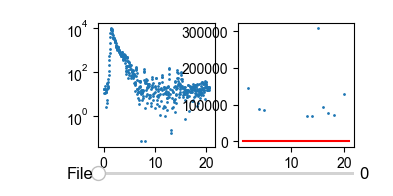

In [6]:
%matplotlib widget
import matplotlib as mat
from matplotlib.widgets import Button, Slider

cms=1/2.54

fig1=plt.figure(figsize=(10*cms,5*cms))
ax1 =plt.subplot(1,2,1)
ax2 =plt.subplot(1,2,2)

mat.rcParams.update({'font.size':12,'font.family':'sans-serif','font.sans-serif':['Arial'],
                     'xtick.labelsize':9,'ytick.labelsize':9,'figure.dpi':300,'savefig.dpi':300})

line,=ax1.plot(Time_fit,Data_fit_s[0,:])
line2=ax1.scatter(Time_fit,Data_exp_s[0,:],s=1)

#line,=ax1.plot(Time_interp,Data_fit_s[0,:])
#line2,=ax1.plot(Time_interp,Data_exp_s[0,:])
ax2.scatter(np.linspace(0,len(File),num=len(File),dtype='int'),ChiSqr,s=1)
ax2.plot(ax2.get_xlim(),[0.95,0.95],color='r')

ax1.set_yscale('log')
#ax1.set_ylim([1E-4,1E1])


def update(k):
    line.set_ydata(Data_fit_s[int(np.floor(k)),:])
    line2.set_offsets(np.stack(Time_fit,Data_exp_s[int(np.floor(k)),:]))
    
    fig1.canvas.draw_idle()

fig1.subplots_adjust(left=0.25, bottom=0.25)
axFile = fig1.add_axes([0.25, 0.1, 0.65, 0.03])

file_slider = Slider(
    ax=axFile,
    label="File",
    valmin=0,
    valmax=len(File)-2,
    valinit=0,
    valfmt='%0.0f'
)

file_slider.on_changed(update)
#plt.tight_layout()


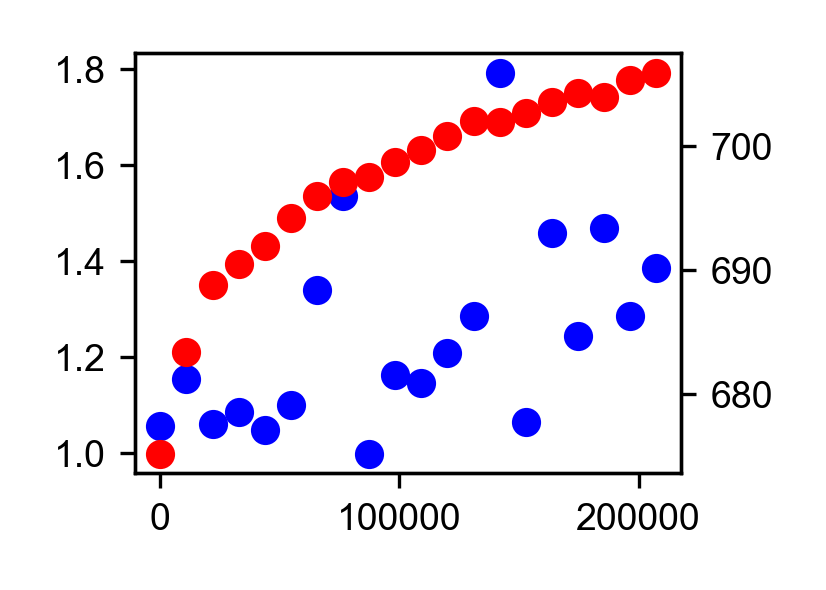

In [8]:
cms=1/2.54

fig1=plt.figure(figsize=(7*cms,5*cms))
ax1 =plt.subplot(1,1,1)
ax2=ax1.twinx()
ax1.scatter(TimeExp,np.max(tau_fit,axis=1),color='b')
ax2.scatter(TimeExp,WavePeak,color='r')
plt.tight_layout()

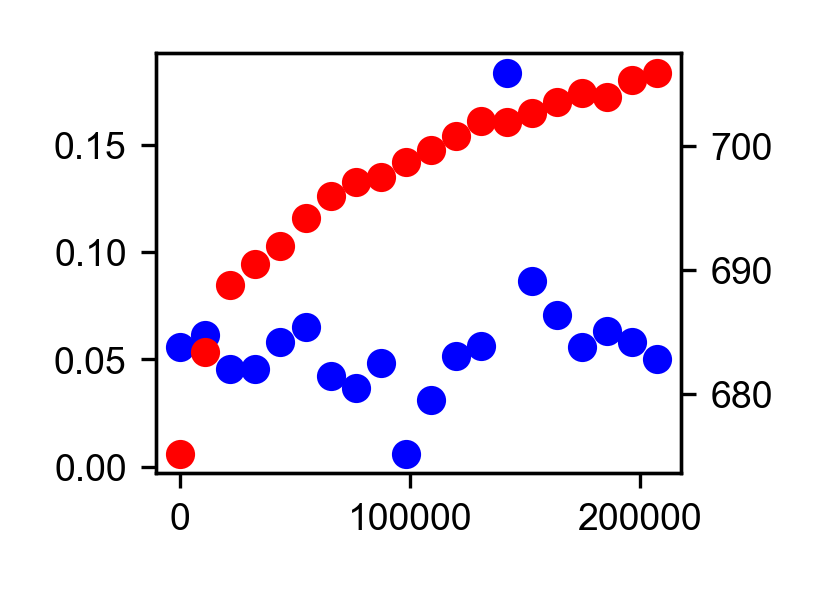

In [9]:
fig1=plt.figure(figsize=(7*cms,5*cms))
ax1 =plt.subplot(1,1,1)
ax2=ax1.twinx()
ax1.scatter(TimeExp,np.min(tau_fit,axis=1),color='b')
ax2.scatter(TimeExp,WavePeak,color='r')
plt.tight_layout()